In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import copy
import pickle
import warnings

import numpy as np

from astropy.table import Table, QTable, Column, join, vstack

import matplotlib.pyplot as plt

import lsst.daf.butler as dafButler
import lsst.afw.image as afwImage

from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [21]:
# Merian data repo
root = '/projects/MERIAN/repo'

butler = dafButler.Butler(root)

## Single Exposure Reduction - Varying Key Background Subtraction Parameters

### Reference catalogs using the default configuration

In [3]:
#visits = [971900, 971677, 971903, 972365]
visits = [971900, 971677]

index = 0

detectors = Table.read('decam_detectors.txt', format='ascii')

### The default reduction 

- `u/sh19/merian_bkg/default`

In [20]:
default_collection = 'u/sh19/merian_bkg/default'

default_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=default_collection)
    ) for ccd in detectors['ccd']])

default_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=default_collection).asAstropy() 
     for ccd in detectors['ccd']])

### Change the `binSize` to 64: 

- `u/sh19/merian_bkg/bin64/`

- Get the useful detectors
    - `ls N708/N708_DECam_c0012_7080.0_400.0/971900/src_DECam_N708_N708_DECam_c0012_7080_0_400_0_971900_* | awk -F_ '{print $16}' > decam_detectors.txt`

In [5]:
bin64_collection = 'u/sh19/merian_bkg/bin64'

bin64_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=bin64_collection)
    ) for ccd in detectors['ccd']])

bin64_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=bin64_collection).asAstropy() 
     for ccd in detectors['ccd']])

### Change the `binSize` to 256: 

- `u/sh19/merian_bkg/bin256/`

In [6]:
bin256_collection = 'u/sh19/merian_bkg/bins256'

bin256_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=bin256_collection)
    ) for ccd in detectors['ccd']])

bin256_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=bin256_collection).asAstropy() 
     for ccd in detectors['ccd']])

### Poly5

In [7]:
poly5_collection = 'u/sh19/merian_bkg/poly5'

poly5_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=poly5_collection)
    ) for ccd in detectors['ccd']])

poly5_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=poly5_collection).asAstropy() 
     for ccd in detectors['ccd']])

### Poly7

In [8]:
poly7_collection = 'u/sh19/merian_bkg/poly7'

poly7_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=poly7_collection)
    ) for ccd in detectors['ccd']])

poly7_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=poly7_collection).asAstropy() 
     for ccd in detectors['ccd']])

### No Weight

In [9]:
visits[index]

971900

In [10]:
nowt_collection = 'u/sh19/merian_bkg/nowt'

nowt_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=nowt_collection)
    ) for ccd in detectors['ccd']])

nowt_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=nowt_collection).asAstropy() 
     for ccd in detectors['ccd']])

#### Specially tailored one

In [15]:
special_collection = 'u/sh19/merian_bkg/tailor'

special_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=visits[index], detector=str(ccd), collections=special_collection)
    ) for ccd in detectors['ccd']])

special_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=visits[index], detector=str(ccd), collections=special_collection).asAstropy() 
     for ccd in detectors['ccd']])

### Basic Statistics

In [18]:
print("# Using the src table of Visit: {:d}".format(visits[index]))

flux_col = 'base_CircularApertureFlux_9_0_instFlux'
flux_err = flux_col + 'Err'

sky_flux_default = default_srcs[default_srcs['sky_source'] & (default_srcs[flux_err] > 0)][flux_col]
sky_flux_bins64 = bin64_srcs[bin64_srcs['sky_source'] & (bin64_srcs[flux_err] > 0)][flux_col]
sky_flux_bins256 = bin256_srcs[bin256_srcs['sky_source'] & (bin256_srcs[flux_err] > 0)][flux_col]
sky_flux_poly5 = poly5_srcs[poly5_srcs['sky_source'] & (poly5_srcs[flux_err] > 0)][flux_col]
sky_flux_poly7 = poly7_srcs[poly7_srcs['sky_source'] & (poly7_srcs[flux_err] > 0)][flux_col]
sky_flux_nowt = nowt_srcs[nowt_srcs['sky_source'] & (nowt_srcs[flux_err] > 0)][flux_col]
sky_flux_special = special_srcs[special_srcs['sky_source'] & (special_srcs[flux_err] > 0)][flux_col]

print("Sky objects using {:s}".format(flux_col))
print("Default : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_default), np.nanstd(sky_flux_default)))
print("Bins 64 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_bins64), np.nanstd(sky_flux_default)))
print("Bins 256: Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_bins256), np.nanstd(sky_flux_bins256)))
print("PolyX=5 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_poly5), np.nanstd(sky_flux_poly5)))
print("PolyX=7 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_poly7), np.nanstd(sky_flux_poly7)))
print("NoWeight: Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_nowt), np.nanstd(sky_flux_nowt)))

print("Special : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_special), np.nanstd(sky_flux_special)))

# Using the src table of Visit: 971900
Sky objects using base_CircularApertureFlux_9_0_instFlux
Default : Median   -29.95 / StdDev   221.26
Bins 64 : Median   -31.23 / StdDev   221.26
Bins 256: Median   -28.31 / StdDev   221.22
PolyX=5 : Median   -29.68 / StdDev   221.30
PolyX=7 : Median   -29.77 / StdDev   217.80
NoWeight: Median   -33.41 / StdDev   222.38
Special : Median   -27.32 / StdDev   221.39


In [19]:
print("# Using the sourceTable table of Visit: {:d}".format(visits[index]))

flux_col = 'ap09Flux'
flux_err = flux_col + 'Err'

sky_flux_default = default_tabs[default_tabs['sky_source'] & (default_tabs[flux_err] > 0)][flux_col]
sky_flux_bins64 = bin64_tabs[bin64_tabs['sky_source'] & (bin64_tabs[flux_err] > 0)][flux_col]
sky_flux_bins256 = bin256_tabs[bin256_tabs['sky_source'] & (bin256_tabs[flux_err] > 0)][flux_col]
sky_flux_poly5 = poly5_tabs[poly5_tabs['sky_source'] & (poly5_tabs[flux_err] > 0)][flux_col]
sky_flux_poly7 = poly7_tabs[poly7_tabs['sky_source'] & (poly7_tabs[flux_err] > 0)][flux_col]
sky_flux_nowt = nowt_tabs[nowt_srcs['sky_source'] & (nowt_tabs[flux_err] > 0)][flux_col]
sky_flux_special = special_tabs[special_tabs['sky_source'] & (special_tabs[flux_err] > 0)][flux_col]

print("Sky objects using {:s}".format(flux_col))
print("Default : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_default), np.nanstd(sky_flux_default)))
print("Bins 64 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_bins64), np.nanstd(sky_flux_default)))
print("Bins 256: Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_bins256), np.nanstd(sky_flux_bins256)))
print("PolyX=5 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_poly5), np.nanstd(sky_flux_poly5)))
print("PolyX=7 : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_poly7), np.nanstd(sky_flux_poly7)))
print("NoWeight: Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_nowt), np.nanstd(sky_flux_nowt)))

print("Special : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_special), np.nanstd(sky_flux_special)))

# Using the sourceTable table of Visit: 971900
Sky objects using ap09Flux
Default : Median   -69.74 / StdDev   515.09
Bins 64 : Median   -72.65 / StdDev   515.09
Bins 256: Median   -66.18 / StdDev   515.01
PolyX=5 : Median   -68.48 / StdDev   515.14
PolyX=7 : Median   -69.16 / StdDev   507.00
NoWeight: Median   -77.13 / StdDev   517.76
Special : Median   -63.51 / StdDev   515.39


## N540 filter

In [22]:
default_n540_collection = 'u/sh19/merian_bkg/default_n540'

default_n540_tabs = vstack(
    [Table.from_pandas(
        butler.get("sourceTable", instrument="DECam", visit=1068722, detector=str(ccd), collections=default_n540_collection)
    ) for ccd in detectors['ccd']])

default_n540_srcs = vstack(
    [butler.get("src", instrument="DECam", visit=1068722, detector=str(ccd), collections=default_n540_collection).asAstropy() 
     for ccd in detectors['ccd']])

In [23]:
print("# Using the sourceTable table of Visit: {:d}".format(1068722))

flux_col = 'ap09Flux'
flux_err = flux_col + 'Err'

sky_flux_default = default_n540_tabs[default_n540_tabs['sky_source'] & (default_n540_tabs[flux_err] > 0)][flux_col]


print("Sky objects using {:s}".format(flux_col))
print("Default : Median {:8.2f} / StdDev {:8.2f}".format(np.nanmedian(sky_flux_default), np.nanstd(sky_flux_default)))

# Using the sourceTable table of Visit: 1068722
Sky objects using ap09Flux
Default : Median   -41.37 / StdDev   356.96


/projects/HSC/LSST/stack_20220318/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


/projects/HSC/LSST/stack_20220318/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/projects/HSC/LSST/stack_20220318/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


-387.98990431549737 3899.6787071704284
-357.8757123279241 3918.2681892580463


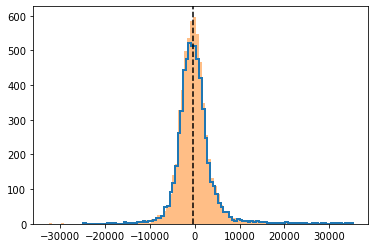

In [25]:
#sky_flux_default = default_srcs[default_srcs['sky_source'] & (default_srcs['base_CircularApertureFlux_35_0_instFluxErr'] > 0)]['base_CircularApertureFlux_35_0_instFlux']
#sky_flux_bins64 = bin64_srcs[bin64_srcs['sky_source'] & (bin64_srcs['base_CircularApertureFlux_35_0_instFluxErr'] > 0)]['base_CircularApertureFlux_35_0_instFlux']

_ = plt.hist(sky_flux_default, bins=100, histtype='step', linewidth=2)
_ = plt.hist(sky_flux_bins256, bins=100, alpha=0.5)

_ = plt.axvline(np.nanmedian(sky_flux_default), c='k', linestyle='--')

#_ = plt.xlim(-1900, 2500)

In [11]:
poly7_tabs.colnames

['coord_ra',
 'coord_dec',
 'ccdVisitId',
 'parentSourceId',
 'x',
 'y',
 'xErr',
 'yErr',
 'ra',
 'decl',
 'calibFlux',
 'calibFluxErr',
 'ap03Flux',
 'ap03FluxErr',
 'ap03Flux_flag',
 'ap06Flux',
 'ap06FluxErr',
 'ap06Flux_flag',
 'ap09Flux',
 'ap09FluxErr',
 'ap09Flux_flag',
 'ap12Flux',
 'ap12FluxErr',
 'ap12Flux_flag',
 'ap17Flux',
 'ap17FluxErr',
 'ap17Flux_flag',
 'ap25Flux',
 'ap25FluxErr',
 'ap25Flux_flag',
 'ap35Flux',
 'ap35FluxErr',
 'ap35Flux_flag',
 'ap50Flux',
 'ap50FluxErr',
 'ap50Flux_flag',
 'ap70Flux',
 'ap70FluxErr',
 'ap70Flux_flag',
 'sky',
 'skyErr',
 'psfFlux',
 'psfFluxErr',
 'ixx',
 'iyy',
 'ixy',
 'ixxPSF',
 'iyyPSF',
 'ixyPSF',
 'gaussianFlux',
 'gaussianFluxErr',
 'extendedness',
 'localPhotoCalib',
 'localPhotoCalib_flag',
 'localPhotoCalibErr',
 'localWcs_flag',
 'localWcs_CDMatrix_2_1',
 'localWcs_CDMatrix_1_1',
 'localWcs_CDMatrix_1_2',
 'localWcs_CDMatrix_2_2',
 'blendedness_abs',
 'blendedness_flag',
 'blendedness_flag_noCentroid',
 'blendedness_flag_

In [75]:
default_srcs.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'calib_detected',
 'calib_psf_candidate',
 'calib_psf_used',
 'calib_psf_reserved',
 'deblend_nChild',
 'deblend_deblendedAsPsf',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psf_instFlux',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_skipped',
 'deblend_rampedTemplate',
 'deblend_patchedTemplate',
 'deblend_hasStrayFlux',
 'deblend_peak_center_x',
 'deblend_peak_center_y',
 'deblend_peakId',
 'deblend_nPeaks',
 'deblend_parentNPeaks',
 'sky_source',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_SdssCentroid_x',
 'slot_Centroid_x',
 'base_SdssCentroid_y',
 'slot_Centroid_y',
 'base_SdssCentroid_xErr',
 'slot_Centroid_xErr',
 'base_SdssCentroid_yErr',
 'slot_Centroid_yErr',
 'base_SdssCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 '